In [1]:
import dask_awkward as dak
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import dask_awkward as dak
import numpy as np
import json
import argparse
import os
from distributed import Client
import time    
import tqdm
import mplhep as hep
import matplotlib.pyplot as plt
import matplotlib
import glob
hep.style.use("CMS")
from dask_gateway import Gateway
# gateway = Gateway(
#     "http://dask-gateway-k8s.geddes.rcac.purdue.edu/",
#     proxy_address="traefik-dask-gateway-k8s.cms.geddes.rcac.purdue.edu:8786",
# )
# cluster_info = gateway.list_clusters()[0]# get the first cluster by default. There only should be one anyways
# client = gateway.connect(cluster_info.name).get_client()
# print("Gateway Client created")
client =  Client(n_workers=30,  threads_per_worker=2, processes=True, memory_limit='10 GiB') 

/depot/cms/kernels/coffea2024/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34823 instead
  warnings.warn(


In [2]:
def get_calib_categories(events):
    BB = ((abs(events["mu1_eta"])<=0.9) & (abs(events["mu2_eta"])<=0.9))
    BO = ((abs(events["mu1_eta"])<=0.9) & ((abs(events["mu2_eta"])>0.9) & (abs(events["mu2_eta"]) <=1.8)))
    BE = ((abs(events["mu1_eta"])<=0.9) & ((abs(events["mu2_eta"])>1.8) & (abs(events["mu2_eta"]) <=2.4)))
    OB = (((abs(events["mu1_eta"])>0.9) & (abs(events["mu1_eta"]) <=1.8)) & (abs(events["mu2_eta"])<=0.9))
    OO = (((abs(events["mu1_eta"])>0.9) & (abs(events["mu1_eta"]) <=1.8)) & ((abs(events["mu2_eta"])>0.9) & (abs(events["mu2_eta"]) <=1.8)))
    OE = (((abs(events["mu1_eta"])>0.9) & (abs(events["mu1_eta"]) <=1.8)) & ((abs(events["mu2_eta"])>1.8) & (abs(events["mu2_eta"]) <=2.4)))
    EB = (((abs(events["mu1_eta"])>1.8) & (abs(events["mu1_eta"]) <=2.4)) & (abs(events["mu2_eta"])<=0.9))
    EO = (((abs(events["mu1_eta"])>1.8) & (abs(events["mu1_eta"]) <=2.4)) & ((abs(events["mu2_eta"])>0.9) & (abs(events["mu2_eta"]) <=1.8)))
    EE = (((abs(events["mu1_eta"])>1.8) & (abs(events["mu1_eta"]) <=2.4)) & ((abs(events["mu2_eta"])>1.8) & (abs(events["mu2_eta"]) <=2.4)))
    categories = [((events["mu1_pt"]>30)&(events["mu1_pt"]<=45)&(BB | OB | EB)),
                          ((events["mu1_pt"]>30)&(events["mu1_pt"]<=45)&(BO | OO | EO)),
                          ((events["mu1_pt"]>30)&(events["mu1_pt"]<=45)&(BE | OE | EE)),
                          ((events["mu1_pt"]>45)&(events["mu1_pt"]<=52)&BB),
                          ((events["mu1_pt"]>45)&(events["mu1_pt"]<=52)&BO),
                          ((events["mu1_pt"]>45)&(events["mu1_pt"]<=52)&BE),
                          ((events["mu1_pt"]>45)&(events["mu1_pt"]<=52)&OB),
                          ((events["mu1_pt"]>45)&(events["mu1_pt"]<=52)&OO),
                          ((events["mu1_pt"]>45)&(events["mu1_pt"]<=52)&OE),
                          ((events["mu1_pt"]>45)&(events["mu1_pt"]<=52)&EB),
                          ((events["mu1_pt"]>45)&(events["mu1_pt"]<=52)&EO),
                          ((events["mu1_pt"]>45)&(events["mu1_pt"]<=52)&EE),
                  # voigtian start here onwards
                          ((events["mu1_pt"]>52)&(events["mu1_pt"]<=62)&BB),
                          ((events["mu1_pt"]>52)&(events["mu1_pt"]<=62)&BO),
                          ((events["mu1_pt"]>52)&(events["mu1_pt"]<=62)&BE),
                          ((events["mu1_pt"]>52)&(events["mu1_pt"]<=62)&OB),
                          ((events["mu1_pt"]>52)&(events["mu1_pt"]<=62)&OO),
                          ((events["mu1_pt"]>52)&(events["mu1_pt"]<=62)&OE),
                          ((events["mu1_pt"]>52)&(events["mu1_pt"]<=62)&EB),
                          ((events["mu1_pt"]>52)&(events["mu1_pt"]<=62)&EO),
                          ((events["mu1_pt"]>52)&(events["mu1_pt"]<=62)&EE),
                          ((events["mu1_pt"]>62)&(events["mu1_pt"]<=200)&BB),
                          ((events["mu1_pt"]>62)&(events["mu1_pt"]<=200)&BO),
                          ((events["mu1_pt"]>62)&(events["mu1_pt"]<=200)&BE),
                          ((events["mu1_pt"]>62)&(events["mu1_pt"]<=200)&OB),
                          ((events["mu1_pt"]>62)&(events["mu1_pt"]<=200)&OO),
                          ((events["mu1_pt"]>62)&(events["mu1_pt"]<=200)&OE),
                          ((events["mu1_pt"]>62)&(events["mu1_pt"]<=200)&EB),
                          ((events["mu1_pt"]>62)&(events["mu1_pt"]<=200)&EO),
                          ((events["mu1_pt"]>62)&(events["mu1_pt"]<=200)&EE),]
    return categories

In [3]:
# get data events
# common_load_path = "/depot/cms/users/yun79/results/stage1/Run2StorageTest/2018/f1_0"
common_load_path = "/work/users/yun79/stage1_output/Run2StorageTest/2018/f1_0"
data_load_path = common_load_path+"/data*/*/*.parquet"

data_events = dak.from_parquet(data_load_path) 
# we're only interested in ZCR
filter = ak.fill_none(data_events["z_peak"], value=False)
data_events = data_events[filter]



In [4]:
# get top MC 
secondary_MC_strs = [
    "ttjet*", # all TT samples
    "st_tw*", # single Top samples
]
filelist_big = []
for mc_str in secondary_MC_strs:
    filelist = glob.glob(common_load_path + f"/{mc_str}/*/*.parquet")
    filelist_big += filelist
top_events = dak.from_parquet(filelist_big) 
# we're only interested in ZCR
filter = ak.fill_none(top_events["z_peak"], value=False)

top_events = top_events[filter]

# get diboson MC
secondary_MC_strs = [    
    "ww*", # diboson samples
    "wz*", # diboson samples
    "zz*", # diboson samples
]
filelist_big = []
for mc_str in secondary_MC_strs:
    filelist = glob.glob(common_load_path + f"/{mc_str}/*/*.parquet")
    filelist_big += filelist
vv_events = dak.from_parquet(filelist_big) 
# we're only interested in ZCR
filter = ak.fill_none(vv_events["z_peak"], value=False)

vv_events = vv_events[filter]


In [5]:
"""
Eager load variable all at once Zip Test
"""
import time
time_step = time.time()
binning = np.linspace(*[70, 110, 100])
# fraction_weight = ak.to_numpy(1/events.fraction.compute())
fields_of_interest = ["mu1_pt", "mu1_eta", "mu2_eta","dimuon_mass", "weights", "fraction"]
data_events = data_events[fields_of_interest]
top_events = top_events[fields_of_interest]
vv_events = vv_events[fields_of_interest]
# zipping prior to computing adds slight runtime acceleration
data_events = ak.zip({
    field : data_events[field] for field in data_events.fields
}).compute()
top_events = ak.zip({
    field : top_events[field] for field in top_events.fields
}).compute()
vv_events = ak.zip({
    field : vv_events[field] for field in vv_events.fields
}).compute()



In [7]:

# data_categories = get_calib_categories(data_events)
# top_categories = get_calib_categories(top_events)
# vv_categories = get_calib_categories(vv_events)
# for idx in range(len(data_categories)):
#     # Data ----------------------------------------------------------------------------
#     cat_selection = data_categories[idx]
#     fraction_weight = 1/data_events.fraction
#     weights = data_events.weights*fraction_weight*cat_selection
#     dimuon_mass = ak.fill_none(data_events.dimuon_mass, value=-999.0)
#     filter = (dimuon_mass!=-999.0) & (weights != 0)
#     dimuon_mass = dimuon_mass[filter]
#     weights = weights[filter]
#     data_hist, _ = np.histogram(dimuon_mass, bins=binning, weights = weights)
#     # Top ------------------------------------------------------------------------------------
#     cat_selection = top_categories[idx]
#     weights = top_events.weights*cat_selection
#     weights = weights * 1000 # for visibility
#     dimuon_mass = ak.fill_none(top_events.dimuon_mass, value=-999.0)
#     filter = (dimuon_mass!=-999.0) & (weights != 0)
#     dimuon_mass = dimuon_mass[filter]
#     weights = weights[filter]
#     top_hist, _ = np.histogram(dimuon_mass, bins=binning, weights = weights)

#     # VV ------------------------------------------------------------------------------------
#     cat_selection = vv_categories[idx]
#     weights = vv_events.weights*cat_selection
#     weights = weights * 1000 # for visibility
#     dimuon_mass = ak.fill_none(vv_events.dimuon_mass, value=-999.0)
#     filter = (dimuon_mass!=-999.0) & (weights != 0)
#     dimuon_mass = dimuon_mass[filter]
#     weights = weights[filter]
#     vv_hist, _ = np.histogram(dimuon_mass, bins=binning, weights = weights)
    

#     fig, ax_main = plt.subplots()
#     hep.histplot(
#         data_hist, xerr=True, 
#         # yerr=data_err,
#         bins=binning, stack=False, histtype='errorbar', color='black', 
#         label='Data', ax=ax_main
#     )
#     hep.histplot(top_hist, bins=binning, 
#                              stack=False, 
#                              histtype='step', 
#                              label="(TT + SingleTop) x 1,000", 
#                              # sort='label_r', 
#                              color="Green", 
#                              ax=ax_main
#     )
#     hep.histplot(vv_hist, bins=binning, 
#                              stack=False, 
#                              histtype='step', 
#                              label="Diboson x 1,000", 
#                              # sort='label_r', 
#                              color="Blue", 
#                              ax=ax_main
#     )

#     ax_main.legend(loc="upper right")
#     ax_main.set_xlabel("dimuon mass [GeV]")
#     ax_main.set_title(f"Cat {idx} ZCR mass distribution")
#     plt.savefig(f"./cat{idx}.pdf")
#     ax_main.set_yscale('log')
#     ax_main.set_ylim(0.01, 1e9)
#     plt.savefig(f"./cat{idx}_log.pdf")
#     print(f"time elapsed in : {time.time()-time_step}")
#     time_step = time.time()
#     plt.close()
#     plt.clf()

In [18]:
"""
Plotting over pT and abs(eta)
category inclusive
"""
# get data events
# common_load_path = "/depot/cms/users/yun79/results/stage1/Run2StorageTest/2018/f1_0"
common_load_path = "/work/users/yun79/stage1_output/Run2StorageTest/2018/f1_0"
data_load_path = common_load_path+"/data*/*/*.parquet"
# data_load_path = common_load_path+"/data_C/*/*.parquet"

data_events = dak.from_parquet(data_load_path) 
# we're only interested in ZCR
filter = ak.fill_none(data_events["z_peak"], value=False)
data_events = data_events[filter]

# get top MC 
secondary_MC_strs = [
    "ttjet*", # all TT samples
    "st_tw*", # single Top samples
]
filelist_big = []
for mc_str in secondary_MC_strs:
    filelist = glob.glob(common_load_path + f"/{mc_str}/*/*.parquet")
    filelist_big += filelist
top_events = dak.from_parquet(filelist_big) 
# we're only interested in ZCR
filter = ak.fill_none(top_events["z_peak"], value=False)

top_events = top_events[filter]

# get diboson MC
secondary_MC_strs = [    
    "ww*", # diboson samples
    "wz*", # diboson samples
    "zz*", # diboson samples
]
filelist_big = []
for mc_str in secondary_MC_strs:
    filelist = glob.glob(common_load_path + f"/{mc_str}/*/*.parquet")
    filelist_big += filelist
vv_events = dak.from_parquet(filelist_big) 
# we're only interested in ZCR
filter = ak.fill_none(vv_events["z_peak"], value=False)

vv_events = vv_events[filter]


"""
Eager load variable all at once Zip Test
"""
import time
time_step = time.time()
fields_of_interest = ["mu1_pt","mu2_pt", "mu1_eta", "mu2_eta","dimuon_mass", "weights", "fraction"]
data_events = data_events[fields_of_interest]
top_events = top_events[fields_of_interest]
vv_events = vv_events[fields_of_interest]
# zipping prior to computing adds slight runtime acceleration
data_events = ak.zip({
    field : data_events[field] for field in data_events.fields
}).compute()
top_events = ak.zip({
    field : top_events[field] for field in top_events.fields
}).compute()
vv_events = ak.zip({
    field : vv_events[field] for field in vv_events.fields
}).compute()



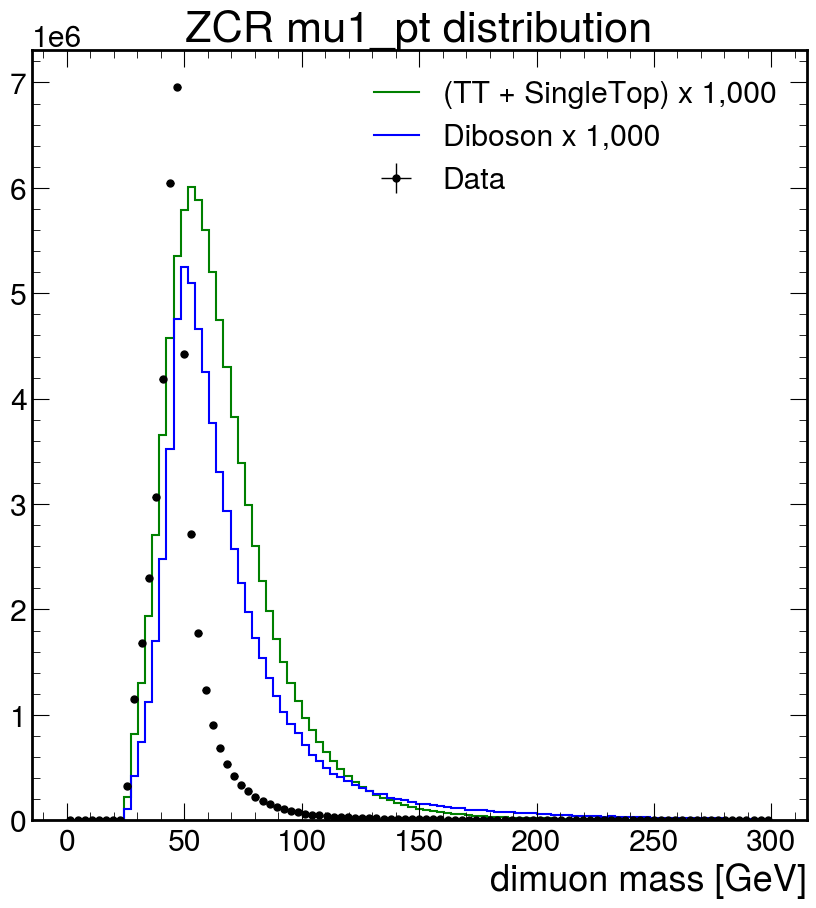

time elapsed in : 53.17374563217163


<Figure size 1000x1000 with 0 Axes>

In [19]:
binning = np.linspace(*[0, 300, 100])
val_str = "mu1_pt"

# Data ----------------------------------------------------------------------------
fraction_weight = 1/data_events.fraction
weights = data_events.weights*fraction_weight
value = ak.fill_none(data_events[val_str], value=-999.0)
filter = (value!=-999.0) & (weights != 0)
value = value[filter]
weights = weights[filter]
data_hist, _ = np.histogram(value, bins=binning, weights = weights)
# Top ------------------------------------------------------------------------------------
weights = top_events.weights
weights = weights * 1000 # for visibility
value = ak.fill_none(top_events[val_str], value=-999.0)
filter = (value!=-999.0) & (weights != 0)
value = value[filter]
weights = weights[filter]
top_hist, _ = np.histogram(value, bins=binning, weights = weights)

# VV ------------------------------------------------------------------------------------
weights = vv_events.weights
weights = weights * 1000 # for visibility
value = ak.fill_none(vv_events[val_str], value=-999.0)
filter = (value!=-999.0) & (weights != 0)
value = value[filter]
weights = weights[filter]
vv_hist, _ = np.histogram(value, bins=binning, weights = weights)


fig, ax_main = plt.subplots()
hep.histplot(
    data_hist, xerr=True, 
    # yerr=data_err,
    bins=binning, stack=False, histtype='errorbar', color='black', 
    label='Data', ax=ax_main
)
hep.histplot(top_hist, bins=binning, 
                         stack=False, 
                         histtype='step', 
                         label="(TT + SingleTop) x 1,000", 
                         # sort='label_r', 
                         color="Green", 
                         ax=ax_main
)
hep.histplot(vv_hist, bins=binning, 
                         stack=False, 
                         histtype='step', 
                         label="Diboson x 1,000", 
                         # sort='label_r', 
                         color="Blue", 
                         ax=ax_main
)

ax_main.legend(loc="upper right")
ax_main.set_xlabel("dimuon mass [GeV]")
ax_main.set_title(f"ZCR {val_str} distribution")
# plt.savefig(f"./ZCR_{val_str}.pdf")
plt.show()
# ax_main.set_yscale('log')
# ax_main.set_ylim(0.01, 1e9)
# plt.savefig(f"./cat{idx}_log.pdf")
print(f"time elapsed in : {time.time()-time_step}")
time_step = time.time()
plt.close()
plt.clf()

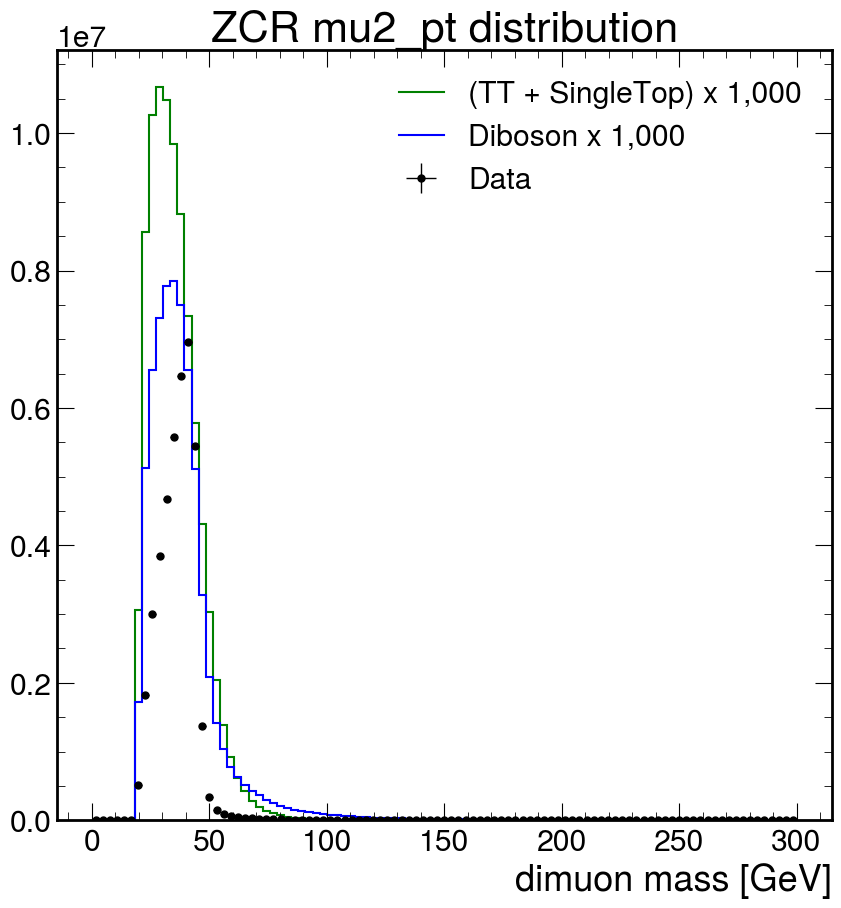

time elapsed in : 5.9598822593688965


<Figure size 1000x1000 with 0 Axes>

In [20]:
binning = np.linspace(*[0, 300, 100])
val_str = "mu2_pt"

# Data ----------------------------------------------------------------------------
fraction_weight = 1/data_events.fraction
weights = data_events.weights*fraction_weight
value = ak.fill_none(data_events[val_str], value=-999.0)
filter = (value!=-999.0) & (weights != 0)
value = value[filter]
weights = weights[filter]
data_hist, _ = np.histogram(value, bins=binning, weights = weights)
# Top ------------------------------------------------------------------------------------
weights = top_events.weights
weights = weights * 1000 # for visibility
value = ak.fill_none(top_events[val_str], value=-999.0)
filter = (value!=-999.0) & (weights != 0)
value = value[filter]
weights = weights[filter]
top_hist, _ = np.histogram(value, bins=binning, weights = weights)

# VV ------------------------------------------------------------------------------------
weights = vv_events.weights
weights = weights * 1000 # for visibility
value = ak.fill_none(vv_events[val_str], value=-999.0)
filter = (value!=-999.0) & (weights != 0)
value = value[filter]
weights = weights[filter]
vv_hist, _ = np.histogram(value, bins=binning, weights = weights)


fig, ax_main = plt.subplots()
hep.histplot(
    data_hist, xerr=True, 
    # yerr=data_err,
    bins=binning, stack=False, histtype='errorbar', color='black', 
    label='Data', ax=ax_main
)
hep.histplot(top_hist, bins=binning, 
                         stack=False, 
                         histtype='step', 
                         label="(TT + SingleTop) x 1,000", 
                         # sort='label_r', 
                         color="Green", 
                         ax=ax_main
)
hep.histplot(vv_hist, bins=binning, 
                         stack=False, 
                         histtype='step', 
                         label="Diboson x 1,000", 
                         # sort='label_r', 
                         color="Blue", 
                         ax=ax_main
)

ax_main.legend(loc="upper right")
ax_main.set_xlabel("dimuon mass [GeV]")
ax_main.set_title(f"ZCR {val_str} distribution")
# plt.savefig(f"./ZCR_{val_str}.pdf")
plt.show()
# ax_main.set_yscale('log')
# ax_main.set_ylim(0.01, 1e9)
# plt.savefig(f"./cat{idx}_log.pdf")
print(f"time elapsed in : {time.time()-time_step}")
time_step = time.time()
plt.close()
plt.clf()

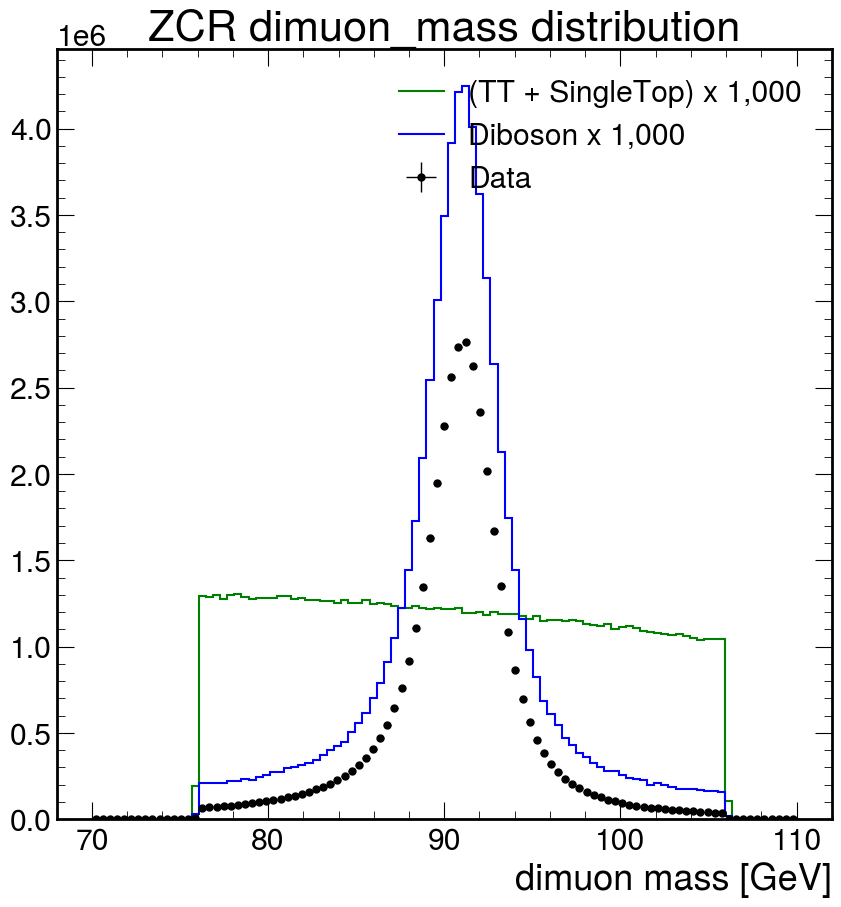

time elapsed in : 30.203426122665405


<Figure size 1000x1000 with 0 Axes>

In [25]:
binning = np.linspace(*[70, 110, 100])
val_str = "dimuon_mass"

# Data ----------------------------------------------------------------------------
fraction_weight = 1/data_events.fraction
weights = data_events.weights*fraction_weight
value = ak.fill_none(data_events[val_str], value=-999.0)
filter = (value!=-999.0) & (weights != 0)
value = value[filter]
weights = weights[filter]
data_hist, _ = np.histogram(value, bins=binning, weights = weights)
# Top ------------------------------------------------------------------------------------
weights = top_events.weights
weights = weights * 1000 # for visibility
value = ak.fill_none(top_events[val_str], value=-999.0)
filter = (value!=-999.0) & (weights != 0)
value = value[filter]
weights = weights[filter]
top_hist, _ = np.histogram(value, bins=binning, weights = weights)

# VV ------------------------------------------------------------------------------------
weights = vv_events.weights
weights = weights * 1000 # for visibility
value = ak.fill_none(vv_events[val_str], value=-999.0)
filter = (value!=-999.0) & (weights != 0)
value = value[filter]
weights = weights[filter]
vv_hist, _ = np.histogram(value, bins=binning, weights = weights)


fig, ax_main = plt.subplots()
hep.histplot(
    data_hist, xerr=True, 
    # yerr=data_err,
    bins=binning, stack=False, histtype='errorbar', color='black', 
    label='Data', ax=ax_main
)
hep.histplot(top_hist, bins=binning, 
                         stack=False, 
                         histtype='step', 
                         label="(TT + SingleTop) x 1,000", 
                         # sort='label_r', 
                         color="Green", 
                         ax=ax_main
)
hep.histplot(vv_hist, bins=binning, 
                         stack=False, 
                         histtype='step', 
                         label="Diboson x 1,000", 
                         # sort='label_r', 
                         color="Blue", 
                         ax=ax_main
)

ax_main.legend(loc="upper right")
ax_main.set_xlabel("dimuon mass [GeV]")
ax_main.set_title(f"ZCR {val_str} distribution")
# plt.savefig(f"./ZCR_{val_str}.pdf")
plt.show()
# ax_main.set_yscale('log')
# ax_main.set_ylim(0.01, 1e9)
# plt.savefig(f"./cat{idx}_log.pdf")
print(f"time elapsed in : {time.time()-time_step}")
time_step = time.time()
plt.close()
plt.clf()

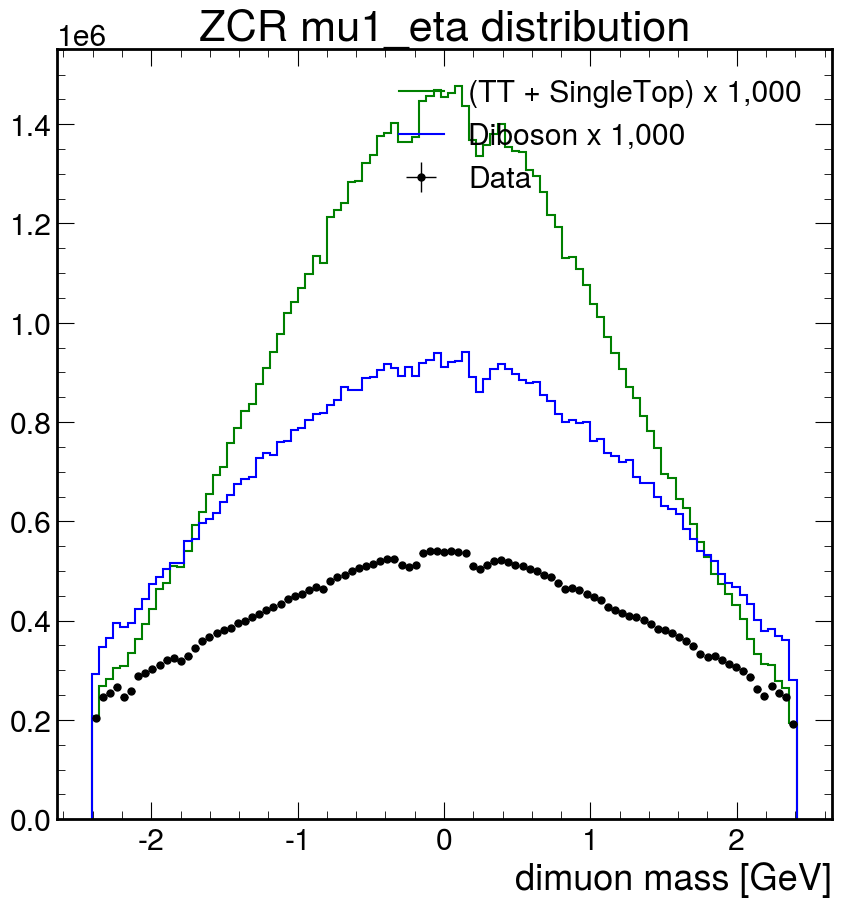

time elapsed in : 6.148069143295288


<Figure size 1000x1000 with 0 Axes>

In [24]:
val_str = "mu1_eta"

# Data ----------------------------------------------------------------------------
fraction_weight = 1/data_events.fraction
weights = data_events.weights*fraction_weight
value = ak.fill_none(data_events[val_str], value=-999.0)
filter = (value!=-999.0) & (weights != 0)
value = value[filter]
weights = weights[filter]
binning = np.linspace(*[np.min(value), np.max(value), 100])
data_hist, _ = np.histogram(value, bins=binning, weights = weights)
# Top ------------------------------------------------------------------------------------
weights = top_events.weights
weights = weights * 1000 # for visibility
value = ak.fill_none(top_events[val_str], value=-999.0)
filter = (value!=-999.0) & (weights != 0)
value = value[filter]
weights = weights[filter]
top_hist, _ = np.histogram(value, bins=binning, weights = weights)

# VV ------------------------------------------------------------------------------------
weights = vv_events.weights
weights = weights * 1000 # for visibility
value = ak.fill_none(vv_events[val_str], value=-999.0)
filter = (value!=-999.0) & (weights != 0)
value = value[filter]
weights = weights[filter]
vv_hist, _ = np.histogram(value, bins=binning, weights = weights)


fig, ax_main = plt.subplots()
hep.histplot(
    data_hist, xerr=True, 
    # yerr=data_err,
    bins=binning, stack=False, histtype='errorbar', color='black', 
    label='Data', ax=ax_main
)
hep.histplot(top_hist, bins=binning, 
                         stack=False, 
                         histtype='step', 
                         label="(TT + SingleTop) x 1,000", 
                         # sort='label_r', 
                         color="Green", 
                         ax=ax_main
)
hep.histplot(vv_hist, bins=binning, 
                         stack=False, 
                         histtype='step', 
                         label="Diboson x 1,000", 
                         # sort='label_r', 
                         color="Blue", 
                         ax=ax_main
)

ax_main.legend(loc="upper right")
ax_main.set_xlabel("dimuon mass [GeV]")
ax_main.set_title(f"ZCR {val_str} distribution")
# plt.savefig(f"./ZCR_{val_str}.pdf")
plt.show()
# ax_main.set_yscale('log')
# ax_main.set_ylim(0.01, 1e9)
# plt.savefig(f"./cat{idx}_log.pdf")
print(f"time elapsed in : {time.time()-time_step}")
time_step = time.time()
plt.close()
plt.clf()

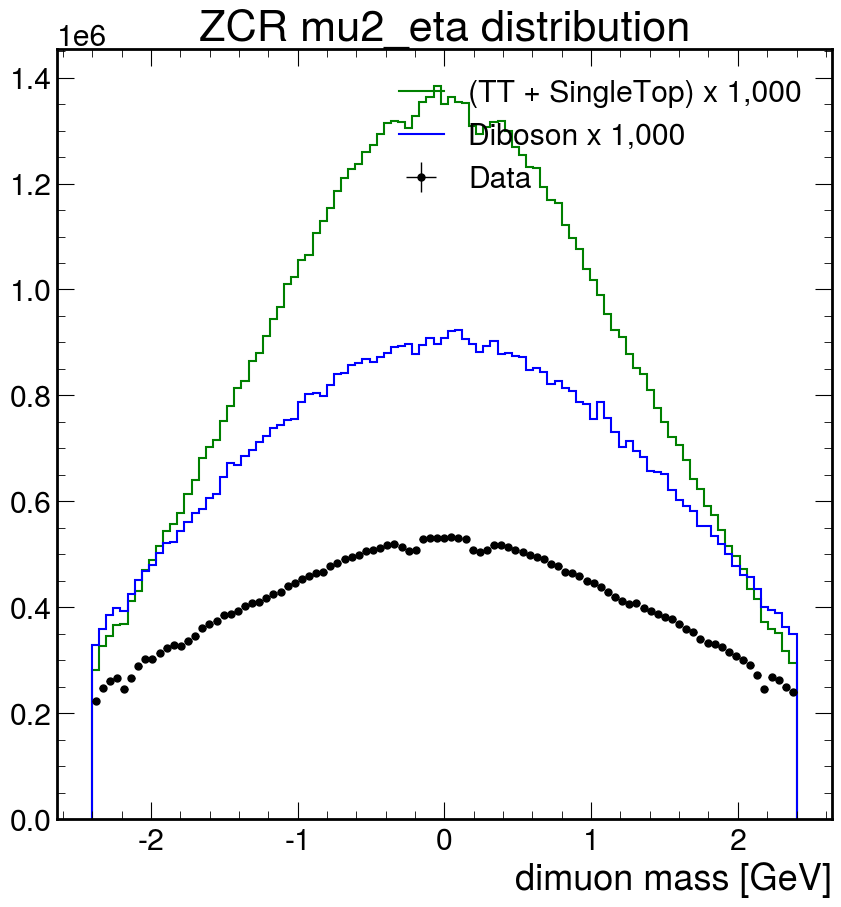

time elapsed in : 5.9908647537231445


<Figure size 1000x1000 with 0 Axes>

In [22]:
val_str = "mu2_eta"

# Data ----------------------------------------------------------------------------
fraction_weight = 1/data_events.fraction
weights = data_events.weights*fraction_weight
value = ak.fill_none(data_events[val_str], value=-999.0)
filter = (value!=-999.0) & (weights != 0)
value = value[filter]
weights = weights[filter]
binning = np.linspace(*[np.min(value), np.max(value), 100])
data_hist, _ = np.histogram(value, bins=binning, weights = weights)
# Top ------------------------------------------------------------------------------------
weights = top_events.weights
weights = weights * 1000 # for visibility
value = ak.fill_none(top_events[val_str], value=-999.0)
filter = (value!=-999.0) & (weights != 0)
value = value[filter]
weights = weights[filter]
top_hist, _ = np.histogram(value, bins=binning, weights = weights)

# VV ------------------------------------------------------------------------------------
weights = vv_events.weights
weights = weights * 1000 # for visibility
value = ak.fill_none(vv_events[val_str], value=-999.0)
filter = (value!=-999.0) & (weights != 0)
value = value[filter]
weights = weights[filter]
vv_hist, _ = np.histogram(value, bins=binning, weights = weights)


fig, ax_main = plt.subplots()
hep.histplot(
    data_hist, xerr=True, 
    # yerr=data_err,
    bins=binning, stack=False, histtype='errorbar', color='black', 
    label='Data', ax=ax_main
)
hep.histplot(top_hist, bins=binning, 
                         stack=False, 
                         histtype='step', 
                         label="(TT + SingleTop) x 1,000", 
                         # sort='label_r', 
                         color="Green", 
                         ax=ax_main
)
hep.histplot(vv_hist, bins=binning, 
                         stack=False, 
                         histtype='step', 
                         label="Diboson x 1,000", 
                         # sort='label_r', 
                         color="Blue", 
                         ax=ax_main
)

ax_main.legend(loc="upper right")
ax_main.set_xlabel("dimuon mass [GeV]")
ax_main.set_title(f"ZCR {val_str} distribution")
# plt.savefig(f"./ZCR_{val_str}.pdf")
plt.show()
# ax_main.set_yscale('log')
# ax_main.set_ylim(0.01, 1e9)
# plt.savefig(f"./cat{idx}_log.pdf")
print(f"time elapsed in : {time.time()-time_step}")
time_step = time.time()
plt.close()
plt.clf()